In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/jdariasl/DiplomadoEPM_2019/master/Modulo3/init.py
from init import init; init(force_download=False)

In [2]:
try:
    %tensorflow_version 2.x
    print ("Using TF2 in Google Colab")
except:
    pass
import numpy as np
import tensorflow as tf
tf.__version__

'2.1.0'

# TensorFlow Components

Tensorflow aims at supporting the **FULL ML LIFECYCLE**, including

- algorithm design 
- model building and training across CPU, GPU or distributed
- streamline data into models both for training and inference
- deploy models into production


In contrast, `sklearn` includes algorithms included already designed and implemented and only supports training and inference within a Python runtime.

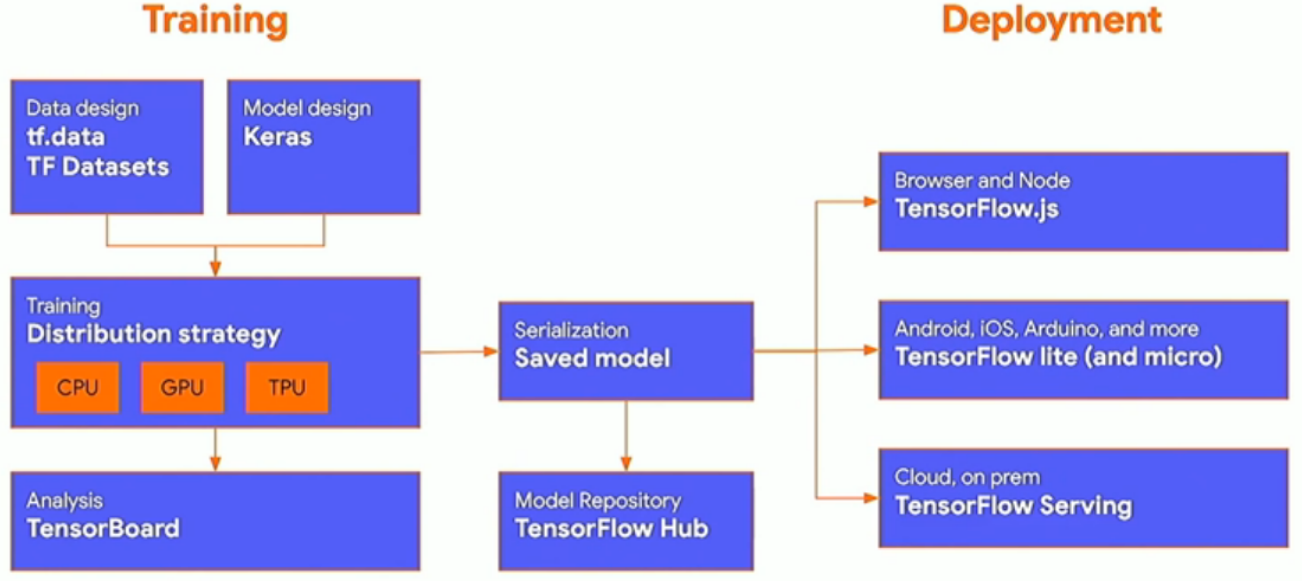

In [3]:
from IPython.display import Image
Image(filename='local/imgs/tf-overview.jpg', width=800)

# Tensorflow Core

at its core, Tensorflow is a specialized computer algebra (symbolic computing) and optimization library, **addressed at solving machine learning problems**

- matrix manipulations (data and model parameters)
- optimization of loss functions

this means that **TF MUST REPRESENT ANY COMPUTATION AS A GRAPH**, so that it can take derivatives, optimize, etc.

## What is symbolic computing?

observe that:

- $x$ and $y$ are symbolic variables, not a references to positions in memory
- $z$ is an expression built up from symbolic variables

In [4]:
import sympy as sy
sy.init_printing(use_latex='matplotlib')
x, y = sy.symbols("x y")
x,y

In [5]:
z = x**2 + x*sy.cos(y)
z

we can evaluate the expresion by providing concrete values for the symbolic variables

In [6]:
z.subs({x: 2, y: sy.pi/4})

and obtain numerical approximations of these values

In [7]:
sy.N(z.subs({x: 2, y: sy.pi/4}))

a **derivative** can be seen as a function that inputs and expression and outputs another expression

observe how we compute $\frac{\partial z}{\partial x}$ and $\frac{\partial z}{\partial y}$

In [8]:
z.diff(x)

In [9]:
z.diff(y)

In [10]:
r = z.diff(x).subs({x: 2, y: sy.pi/4})
r, sy.N(r)

In [11]:
r = z.diff(y).subs({x: 2, y: sy.pi/4})
r, sy.N(r)

**EXERCISE**: draw the computational graph of the expresisons above and show how to differentiate mechanically using the graphs

### Symbolic computing for machine learning

however, generic symbolic computer algebra libraries like [Maxima](http://maxima.sourceforge.net/), [Sage](https://www.sagemath.org/), [Mathematica/WolframAlpha](https://www.wolframalpha.com/) or [Sympy](https://www.sympy.org/) itself, are **generic** packages unable to deal with the expressions generated in ML problems, involving operations on large matrices with data and parameters.

Tensorflow is a specialized computer algebra (symbolic computing) and optimization library, **addressed at solving machine learning problems**

In [145]:

def get_gradients(xval, yval):
    x = tf.Variable(xval, dtype=tf.float32)
    y = tf.Variable(yval, dtype=tf.float32)
    
    with tf.GradientTape(persistent=True) as t:
        z = x**2 + x*tf.cos(y)
        
    return t.gradient(z,x),t.gradient(z,y)

In [146]:
get_gradients(2, np.pi/4)

(<tf.Tensor: shape=(), dtype=float32, numpy=4.7071066>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1.4142135>)

a model usually contains many parameters. Differentiation is usually hidden from us, but **TF always takes care of differentiation**

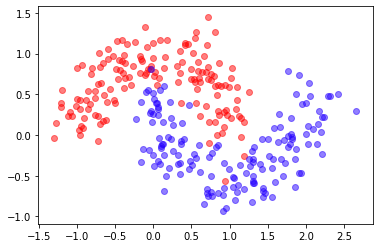

In [240]:
from sklearn.datasets import make_moons
from local.lib import mlutils

X,y = make_moons(300, noise=.2 )
mlutils.plot_2Ddata(X,y)

In [241]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(2))
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 20)                60        
_________________________________________________________________
dense_62 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_63 (Dense)             (None, 2)                 42        
Total params: 522
Trainable params: 522
Non-trainable params: 0
_________________________________________________________________


observe there is a gradient value for each **trainable parameter**

In [242]:
with tf.GradientTape() as t:
    yhat = model(X.astype(np.float32))
t.gradient(yhat, model.trainable_variables)

[<tf.Tensor: shape=(2, 20), dtype=float32, numpy=
 array([[ 9.581448  , -1.1209612 ,  1.5157113 , -0.28844714, -5.2597713 ,
          4.705632  ,  4.736747  ,  6.311697  ,  2.5436711 , 17.154768  ,
         -3.8618455 , -1.3625538 ,  3.4618807 , 14.107719  ,  1.204973  ,
         14.863323  , -4.8014107 ,  5.189046  , -5.9965324 , -4.2106857 ],
        [ 2.15773   , -0.57335365, -0.9653981 , -0.16076915,  3.27454   ,
         -6.453929  , -1.8125919 , -0.47759092, -1.8849552 ,  3.340094  ,
          0.40392792, -0.9163162 , -2.6026633 , -1.8629003 ,  0.05142537,
         -0.5066336 ,  3.3807597 ,  0.6661599 ,  2.6217308 ,  5.7912674 ]],
       dtype=float32)>, <tf.Tensor: shape=(20,), dtype=float32, numpy=
 array([ 13.711776  ,   4.79759   ,  -2.1313515 ,   0.10632479,
         -7.5296736 , -10.416577  ,   4.6329803 ,   4.0511537 ,
         -3.9393308 ,  19.257206  ,  -2.8793776 ,  -0.0406625 ,
          5.8906507 ,  15.61944   ,  -4.0276213 ,  15.774515  ,
         -5.709957  ,   2.89

however, **fit**, **evaluate** and **predict** do all the differentiation and optimization for you

In [243]:
model.fit(X,y, epochs=30, batch_size=2)
model.evaluate(X,y)

Train on 300 samples
Epoch 1/30
300/300 [==============================] - 0s 819us/sample - loss: 0.5787 - accuracy: 0.7500
Epoch 2/30
300/300 [==============================] - 0s 312us/sample - loss: 0.4175 - accuracy: 0.8333
Epoch 3/30
300/300 [==============================] - 0s 313us/sample - loss: 0.3446 - accuracy: 0.8567
Epoch 4/30
300/300 [==============================] - 0s 310us/sample - loss: 0.3148 - accuracy: 0.8500
Epoch 5/30
300/300 [==============================] - 0s 321us/sample - loss: 0.2960 - accuracy: 0.8567
Epoch 6/30
300/300 [==============================] - 0s 324us/sample - loss: 0.2724 - accuracy: 0.8700
Epoch 7/30
300/300 [==============================] - 0s 309us/sample - loss: 0.2513 - accuracy: 0.8833
Epoch 8/30
300/300 [==============================] - 0s 316us/sample - loss: 0.2364 - accuracy: 0.9067
Epoch 9/30
300/300 [==============================] - 0s 318us/sample - loss: 0.2192 - accuracy: 0.9100
Epoch 10/30
300/300 [======================

[0.08475646619995435, 0.98]

observe that predictions are two class probabilities, one for each output neuron

In [244]:
model.predict(X)

array([[1.91281229e-01, 5.27062279e-04],
       [1.58123818e-04, 1.40107557e-01],
       [8.39957297e-02, 9.66641773e-03],
       [1.12672907e-03, 1.99131101e-01],
       [5.28524965e-02, 3.50840949e-03],
       [3.81430262e-04, 8.66242170e-01],
       [2.89136291e-01, 1.11575571e-06],
       [8.10621772e-04, 8.01626503e-01],
       [1.04755037e-01, 2.64137029e-03],
       [3.82708162e-01, 6.54147925e-06],
       [1.98142952e-03, 5.31233788e-01],
       [1.05202373e-03, 5.36866486e-01],
       [2.79411256e-01, 3.12324846e-05],
       [2.29916006e-01, 9.23920525e-05],
       [2.14183740e-02, 6.06514998e-02],
       [1.25209153e-01, 8.11436403e-05],
       [6.98598325e-01, 2.46301930e-08],
       [7.39233103e-03, 4.04877812e-02],
       [1.06309704e-03, 2.12029636e-01],
       [1.00564556e-02, 7.12341443e-02],
       [2.71825789e-04, 8.86054099e-01],
       [3.59473348e-01, 2.94589525e-04],
       [5.60730062e-02, 2.01984949e-04],
       [6.46028761e-03, 2.42863834e-01],
       [2.201922

In [245]:
predict_fn = lambda X: np.argmax(model.predict(X), axis=1)
predict_fn(X)

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1])

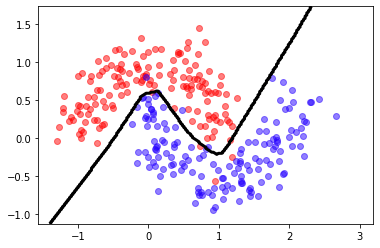

In [246]:
mlutils.plot_2Ddata_with_boundary(predict_fn, X, y)